# Modeling Walkthrough

## Agenda

The goal here is to illustrate a possible workflow for classification modeling with `sklearn`'s `LogisticRegression` model.

SWBAT:

- formulate and implement an iterative modeling workflow.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.impute import MissingIndicator, SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel

# plot_confusion_matrix is a handy visual tool, added in the latest version of scikit-learn
# if you are running an older version, comment out this line and just use confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

## Modeling Steps

1. Build a model based on the [Titanic dataset](https://www.kaggle.com/c/titanic/data) that predicts whether a given person survived or not
2. Evaluate the performance of the model
3. Make changes in an attempt to improve the model
4. Demonstrate whether an improvement was made

## The Data

This dataset has the following columns:

| Variable | Definition | Key |
| -------- | ---------- | --- |
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex | |
| Age | Age in years | |
| sibsp | # of siblings / spouses aboard the Titanic | |
| parch | # of parents / children aboard the Titanic | |
| ticket | Ticket number | |
| fare | Passenger fare | |
| cabin | Cabin number | |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

## Initial Data Understanding and Preparation

Open up the file, get everything into `X` features and `y` target variables, divided into train and test.

In [2]:
df = pd.read_csv("titanic.csv")

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
df.isna().sum()['Age']

177

Age data is missing for about 1 in 9 rows in our dataset.  For now, let's just exclude it, plus the non-numeric columns, and `PassengerId`, which doesn't seem like a real feature, but rather just an artifact of the dataset.

In [6]:
df = df.drop("PassengerId", axis=1)

In [7]:
df.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [8]:
# Pclass are numbers but it's not clear that the difference between 1st and 2nd is the
# same as the difference between 2nd and 3rd
numeric_columns = ["Survived", "SibSp", "Parch", "Fare"]

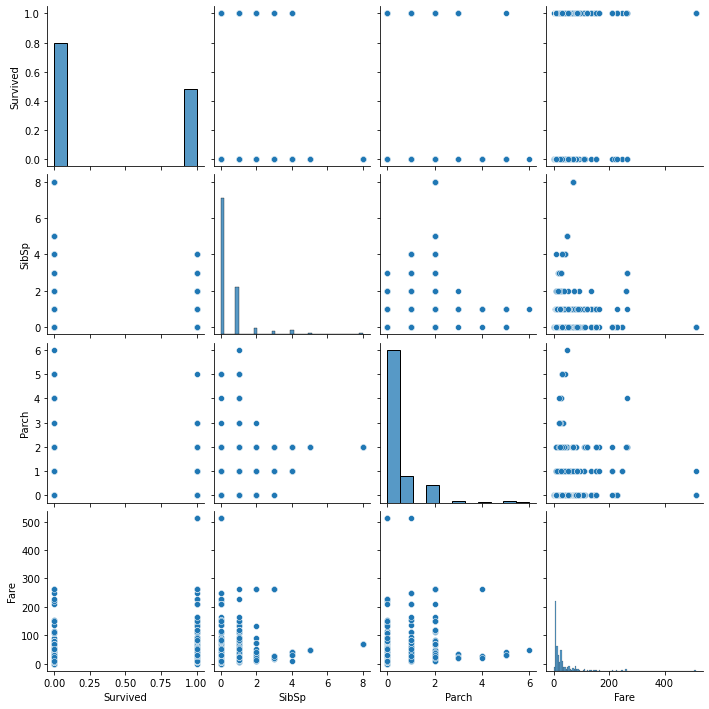

In [9]:
sns.pairplot(df[numeric_columns]);

In [10]:
numeric_df = df[numeric_columns]
X = numeric_df.drop("Survived", axis=1)
y = numeric_df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2021)

## Modeling

Let's start with a completely "dummy" model, that will always choose the majority class.

In [11]:
dummy_model = DummyClassifier(strategy="most_frequent")

Fit the model on our data

In [12]:
dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

We should expect all predictions to be the same

In [13]:
# just grabbing the first 50 to save space
dummy_model.predict(X_train)[:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

## Model Evaluation

In [14]:
cross_val_score(dummy_model, X_train, y_train, cv=3)

array([0.61883408, 0.61883408, 0.62162162])

So, the mean accuracy is a little over 62% if we always guess the majority class.

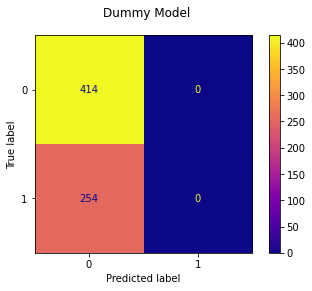

In [15]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

plot_confusion_matrix(dummy_model, X_train, y_train, ax=ax, cmap="plasma");

In [16]:
# just the numbers (this should work even with older scikit-learn)
confusion_matrix(y_train, dummy_model.predict(X_train))

array([[414,   0],
       [254,   0]])

A pretty lopsided confusion matrix!

## Modeling, Part 2

Let's use a logistic regression and compare its performance.

In [17]:
simple_logreg_model = LogisticRegression(random_state=2021)

In [18]:
simple_logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=2021)

Look at the predictions:

In [19]:
simple_logreg_model.predict(X_train)[:50]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0])

Mixture of 1s and 0s this time

## Model Evaluation, Part 2

In [20]:
cross_val_score(simple_logreg_model, X_train, y_train, cv=3)

array([0.66816143, 0.69058296, 0.68468468])

So the mean accuracy is closer to 70% if the model is actually taking in information from the features instead of always guessing the majority class.

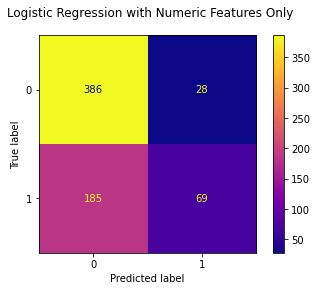

In [21]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with Numeric Features Only")

plot_confusion_matrix(simple_logreg_model, X_train, y_train, ax=ax, cmap="plasma");

In [22]:
confusion_matrix(y_train, simple_logreg_model.predict(X_train))

array([[386,  28],
       [185,  69]])

So, in general we are not labeling many of the "not survived" passengers as "survived", but for "survived" passengers we're getting it wrong most of the time.

## Data Preparation, Part 2

Maybe there is some useful information in the features we are not using yet.  Let's go wild and add all of them!

Note: you can and should add features incrementally in a "real" modeling context.  The engineering effort of encoding the variables can be non-trivial!  But here let's assume that it's not too much work to encode all of them.

Start with a new train-test split that contains all of the features

In [23]:
X = df.drop("Survived", axis=1)
y = df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2021)

In [24]:
X_train.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')

In [25]:
X_train.isna().sum()

Pclass        0
Name          0
Sex           0
Age         129
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       512
Embarked      1
dtype: int64

### Handling Missing Values

Let's be extra cautious and make a separate column to indicate whether there originally was a missing value.

In our training data there are only missing values for a couple of the columns, but we can't be sure about where the test set will be missing data.

The `MissingIndicator` from `sklearn` will mark the missing values in an input array.

In [26]:
indicator_demo = MissingIndicator()

indicator_demo.fit(X_train)

indicator_demo.features_

array([3, 8, 9])

In [27]:
indicator_demo.transform(X_train)[:5, :]

array([[False,  True, False],
       [ True,  True, False],
       [False,  True, False],
       [False,  True, False],
       [False,  True, False]])

In [28]:
X_train.iloc[:5, [3, 8, 9]]

,Age,Cabin,Embarked
784,25.0,NaN,S
568,NaN,NaN,C
381,1.0,NaN,C
694,60.0,NaN,S
844,17.0,NaN,S


In [29]:
indicator = MissingIndicator(features="all")
indicator.fit(X_train)

MissingIndicator(features='all')

In [30]:
def add_missing_indicator_columns(X, indicator):
    """
    Helper function for transforming features
    
    For every feature in X, create another feature indicating whether that feature
    is missing. (This doubles the number of columns in X.)
    """
    
    # create a 2D array of True and False values indicating whether a given feature
    # is missing for that row
    missing_array_bool = indicator.transform(X)
    
    # transform into 1 and 0 for modeling
    missing_array_int = missing_array_bool.astype(int)
    
    # helpful for readability but not needed for modeling
    missing_column_names = [col + "_missing" for col in X.columns]
    
    # convert to df so it we can concat with X
    missing_df = pd.DataFrame(missing_array_int, columns=missing_column_names, index=X.index)
    
    return pd.concat([X, missing_df], axis=1)

In [31]:
X_train = add_missing_indicator_columns(X=X_train, indicator=indicator)

In [33]:
X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_missing,Name_missing,Sex_missing,Age_missing,SibSp_missing,Parch_missing,Ticket_missing,Fare_missing,Cabin_missing,Embarked_missing
784,3,"Ali, Mr. William",male,25.0,0,0,SOTON/O.Q. 3101312,7.0500,NaN,S,0,0,0,0,0,0,0,0,1,0
568,3,"Doharr, Mr. Tannous",male,NaN,0,0,2686,7.2292,NaN,C,0,0,0,1,0,0,0,0,1,0
381,3,"Nakid, Miss. Maria (""Mary"")",female,1.0,0,2,2653,15.7417,NaN,C,0,0,0,0,0,0,0,0,1,0
694,1,"Weir, Col. John",male,60.0,0,0,113800,26.5500,NaN,S,0,0,0,0,0,0,0,0,1,0
844,3,"Culumovic, Mr. Jeso",male,17.0,0,0,315090,8.6625,NaN,S,0,0,0,0,0,0,0,0,1,0


Now that we've specified which values were originally missing, let's fill in those missing values.  This takes two separate imputers because we want to use the mean for numeric data and the majority class for categorical data.

The `SimpleImputer` class fills in the mean value by default, so we'll have to override that for the categorical columns.

In [34]:
numeric_feature_names = ["Age", "SibSp", "Parch", "Fare"]
categorical_feature_names = ["Pclass", "Name", "Sex", "Ticket", "Cabin", "Embarked"]

X_train_numeric = X_train[numeric_feature_names]
X_train_categorical = X_train[categorical_feature_names]

In [35]:
numeric_imputer = SimpleImputer()
numeric_imputer.fit(X_train_numeric)

SimpleImputer()

In [36]:
categorical_imputer = SimpleImputer(strategy="most_frequent")
categorical_imputer.fit(X_train_categorical)

SimpleImputer(strategy='most_frequent')

We'll build a function here to minimize our work of imputation:

In [37]:
def impute_missing_values(X, imputer):
    """
    Given a DataFrame and an imputer, use the imputer to fill in all
    missing values in the DataFrame
    """
    imputed_array = imputer.transform(X)
    imputed_df = pd.DataFrame(imputed_array, columns=X.columns, index=X.index)
    return imputed_df

In [38]:
X_train_numeric = impute_missing_values(X_train_numeric, numeric_imputer)
X_train_categorical = impute_missing_values(X_train_categorical, categorical_imputer)

Double-check to make sure that all of the missing values are gone:

In [39]:
X_train_imputed = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_train_imputed.isna().sum()

Age         0
SibSp       0
Parch       0
Fare        0
Pclass      0
Name        0
Sex         0
Ticket      0
Cabin       0
Embarked    0
dtype: int64

In [40]:
X_train_imputed.head()

,Age,SibSp,Parch,Fare,Pclass,Name,Sex,Ticket,Cabin,Embarked
784,25.00000,0.0,0.0,7.0500,3,"Ali, Mr. William",male,SOTON/O.Q. 3101312,B96 B98,S
568,29.24397,0.0,0.0,7.2292,3,"Doharr, Mr. Tannous",male,2686,B96 B98,C
381,1.00000,0.0,2.0,15.7417,3,"Nakid, Miss. Maria (""Mary"")",female,2653,B96 B98,C
694,60.00000,0.0,0.0,26.5500,1,"Weir, Col. John",male,113800,B96 B98,S
844,17.00000,0.0,0.0,8.6625,3,"Culumovic, Mr. Jeso",male,315090,B96 B98,S


Drop all of the old columns from X_train, then concat the new imputed ones:

In [41]:
X_train = X_train.drop(numeric_feature_names + categorical_feature_names, axis=1)
X_train = pd.concat([X_train_imputed, X_train], axis=1)

In [42]:
X_train.head()

,Age,SibSp,Parch,Fare,Pclass,Name,Sex,Ticket,Cabin,Embarked,Pclass_missing,Name_missing,Sex_missing,Age_missing,SibSp_missing,Parch_missing,Ticket_missing,Fare_missing,Cabin_missing,Embarked_missing
784,25.00000,0.0,0.0,7.0500,3,"Ali, Mr. William",male,SOTON/O.Q. 3101312,B96 B98,S,0,0,0,0,0,0,0,0,1,0
568,29.24397,0.0,0.0,7.2292,3,"Doharr, Mr. Tannous",male,2686,B96 B98,C,0,0,0,1,0,0,0,0,1,0
381,1.00000,0.0,2.0,15.7417,3,"Nakid, Miss. Maria (""Mary"")",female,2653,B96 B98,C,0,0,0,0,0,0,0,0,1,0
694,60.00000,0.0,0.0,26.5500,1,"Weir, Col. John",male,113800,B96 B98,S,0,0,0,0,0,0,0,0,1,0
844,17.00000,0.0,0.0,8.6625,3,"Culumovic, Mr. Jeso",male,315090,B96 B98,S,0,0,0,0,0,0,0,0,1,0


In [43]:
X_train.isna().sum()

Age                 0
SibSp               0
Parch               0
Fare                0
Pclass              0
Name                0
Sex                 0
Ticket              0
Cabin               0
Embarked            0
Pclass_missing      0
Name_missing        0
Sex_missing         0
Age_missing         0
SibSp_missing       0
Parch_missing       0
Ticket_missing      0
Fare_missing        0
Cabin_missing       0
Embarked_missing    0
dtype: int64

### One-Hot Encoding

Now that there are no missing values, convert all of the categorical features into numbers.

In [44]:
def encode_and_concat_feature_train(X_train, feature_name):
    """
    Helper function for transforming training data.  It takes in the full X dataframe and
    feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe
    with that feature transformed into multiple columns of 1s and 0s
    """
    # make a one-hot encoder and fit it to the training data
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    single_feature_df = X_train[[feature_name]]
    ohe.fit(single_feature_df)
    
    # call helper function that actually encodes the feature and concats it
    X_train = encode_and_concat_feature(X_train, feature_name, ohe)
    
    return ohe, X_train

In [45]:
def encode_and_concat_feature(X, feature_name, ohe):
    """
    Helper function for transforming a feature into multiple columns of 1s and 0s. Used
    in both training and testing steps.  Takes in the full X dataframe, feature name, 
    and encoder, and returns the dataframe with that feature transformed into multiple
    columns of 1s and 0s
    """
    # create new one-hot encoded df based on the feature
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0], index=X.index)
    
    # drop the old feature from X and concat the new one-hot encoded df
    X = X.drop(feature_name, axis=1)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

In [46]:
encoders = {}

for categorical_feature in categorical_feature_names:
    ohe, X_train = encode_and_concat_feature_train(X_train, categorical_feature)
    encoders[categorical_feature] = ohe

In [47]:
encoders

{'Pclass': OneHotEncoder(handle_unknown='ignore'),
 'Name': OneHotEncoder(handle_unknown='ignore'),
 'Sex': OneHotEncoder(handle_unknown='ignore'),
 'Ticket': OneHotEncoder(handle_unknown='ignore'),
 'Cabin': OneHotEncoder(handle_unknown='ignore'),
 'Embarked': OneHotEncoder(handle_unknown='ignore')}

In [48]:
X_train.head()

,Age,SibSp,Parch,Fare,Pclass_missing,Name_missing,Sex_missing,Age_missing,SibSp_missing,Parch_missing,...,F E69,F G73,F2,F33,F4,G6,T,C,Q,S
784,25.00000,0.0,0.0,7.0500,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
568,29.24397,0.0,0.0,7.2292,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
381,1.00000,0.0,2.0,15.7417,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
694,60.00000,0.0,0.0,26.5500,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
844,17.00000,0.0,0.0,8.6625,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [49]:
X_train.shape

(668, 1348)

This is...a ridiculous number of columns.  How did we end up with more columns than rows?

(Answer: each unique name and ticket number is now its own column)

## Modeling, Part 3

Let's run a logistic regression on our ridiculous number of columns:

In [50]:
logreg_model = LogisticRegression(random_state=2021)
logreg_model.fit(X_train, y_train)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=2021)

What happened there?  This solver had no problem before.

Answer: it wasn't able to find the minimum with this number of steps in gradient descent.

### Adjustments

Let's try a couple of stopgap measures to get the model to run.

#### More iterations

In [51]:
logreg_model_more_iterations = LogisticRegression(random_state=2021, max_iter=1000)
logreg_model_more_iterations.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=2021)

#### More regularization

Remember that the `C` parameter is the inverse of the regularization strength.

In [52]:
logreg_model_more_regularization = LogisticRegression(random_state=2021, C=0.01)
logreg_model_more_regularization.fit(X_train, y_train)

LogisticRegression(C=0.01, random_state=2021)

#### Higher tolerance

In [53]:
logreg_model_higher_tolerance = LogisticRegression(random_state=2021, tol=50)
logreg_model_higher_tolerance.fit(X_train, y_train)

LogisticRegression(random_state=2021, tol=50)

## Model Evaluation, Part 3

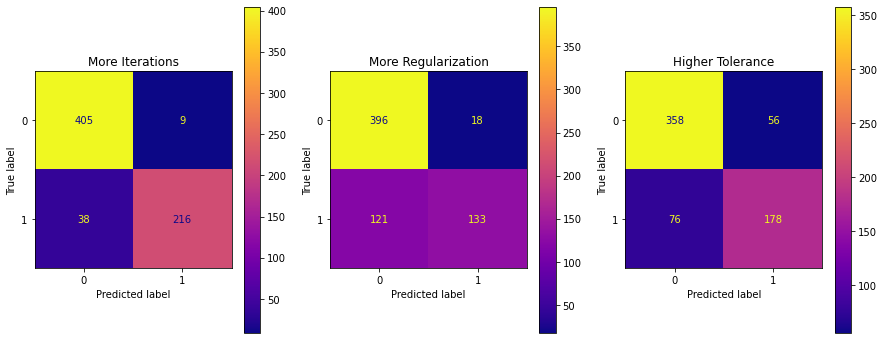

In [54]:
fix, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

axes[0].set_title("More Iterations")
axes[1].set_title("More Regularization")
axes[2].set_title("Higher Tolerance")

plot_confusion_matrix(logreg_model_more_iterations, X_train, y_train,
                      ax=axes[0], cmap="plasma")
plot_confusion_matrix(logreg_model_more_regularization, X_train, y_train,
                      ax=axes[1], cmap="plasma")
plot_confusion_matrix(logreg_model_higher_tolerance, X_train, y_train,
                      ax=axes[2], cmap="plasma");

In [57]:
print(cross_val_score(logreg_model_more_iterations, X_train, y_train, cv=3))
print(cross_val_score(logreg_model_more_regularization, X_train, y_train, cv=3))
print(cross_val_score(logreg_model_higher_tolerance, X_train, y_train, cv=3))

[0.79372197 0.82511211 0.78828829]
[0.74887892 0.74439462 0.73873874]
[0.78923767 0.71300448 0.77927928]


In [60]:
cv_1 = cross_val_score(logreg_model_more_iterations, X_train, y_train, cv=3)
cv_1.mean(), cv_1.std()

(0.8023741230019258, 0.016230489643968175)

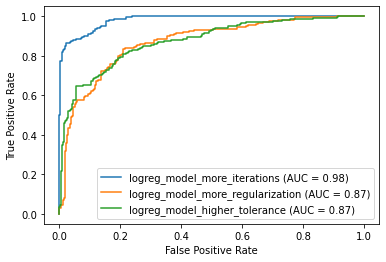

In [61]:
fig, ax = plt.subplots()

plot_roc_curve(logreg_model_more_iterations, X_train, y_train, 
               name='logreg_model_more_iterations', ax=ax)
plot_roc_curve(logreg_model_more_regularization, X_train, y_train, 
               name='logreg_model_more_regularization', ax=ax)
plot_roc_curve(logreg_model_higher_tolerance, X_train, y_train, 
               name='logreg_model_higher_tolerance', ax=ax)

## Data Preparation, Part 3

Let's scale all of the features, so the model isn't overly penalizing age and fare

In [62]:
scaler = StandardScaler()

scaler.fit(X_train)

StandardScaler()

In [63]:
def scale_values(X, scaler):
    """
    Given a DataFrame and a fitted scaler, use the scaler to scale all of the features
    """
    scaled_array = scaler.transform(X)
    scaled_df = pd.DataFrame(scaled_array, columns=X.columns, index=X.index)
    return scaled_df

In [64]:
X_train = scale_values(X_train, scaler)

In [65]:
X_train.head()

,Age,SibSp,Parch,Fare,Pclass_missing,Name_missing,Sex_missing,Age_missing,SibSp_missing,Parch_missing,...,F E69,F G73,F2,F33,F4,G6,T,C,Q,S
784,-3.248270e-01,-0.487594,-0.494524,-0.517766,0.0,0.0,0.0,-0.489216,0.0,0.0,...,-0.03872,-0.03872,-0.067166,-0.0548,-0.03872,-0.067166,-0.03872,-0.489216,-0.29656,0.614263
568,-2.719192e-16,-0.487594,-0.494524,-0.514124,0.0,0.0,0.0,2.044088,0.0,0.0,...,-0.03872,-0.03872,-0.067166,-0.0548,-0.03872,-0.067166,-0.03872,2.044088,-0.29656,-1.627966
381,-2.161750e+00,-0.487594,1.998625,-0.341142,0.0,0.0,0.0,-0.489216,0.0,0.0,...,-0.03872,-0.03872,-0.067166,-0.0548,-0.03872,-0.067166,-0.03872,2.044088,-0.29656,-1.627966
694,2.354019e+00,-0.487594,-0.494524,-0.121507,0.0,0.0,0.0,-0.489216,0.0,0.0,...,-0.03872,-0.03872,-0.067166,-0.0548,-0.03872,-0.067166,-0.03872,-0.489216,-0.29656,0.614263
844,-9.371347e-01,-0.487594,-0.494524,-0.484998,0.0,0.0,0.0,-0.489216,0.0,0.0,...,-0.03872,-0.03872,-0.067166,-0.0548,-0.03872,-0.067166,-0.03872,-0.489216,-0.29656,0.614263


## Modeling, Part 4

Now that the data is scaled, let's see if we can fit the model without tweaking any hyperparameters.

In [66]:
logreg_model = LogisticRegression(random_state=2021)
logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=2021)

## Model Evaluation, Part 4

Now that we are able to run a logistic regression with default hyperparameters, let's see how that performs.

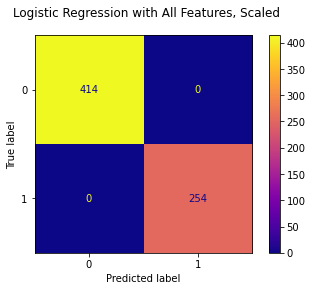

In [67]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with All Features, Scaled")

plot_confusion_matrix(logreg_model, X_train, y_train, ax=ax, cmap="plasma");

In [68]:
all_features_cross_val_score = cross_val_score(logreg_model, X_train, y_train, cv=3)
all_features_cross_val_score

array([0.77130045, 0.71748879, 0.8018018 ])

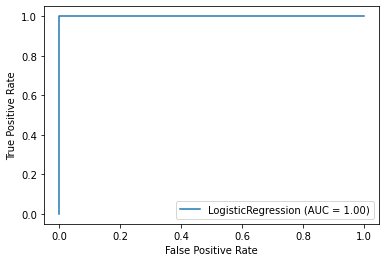

In [69]:
plot_roc_curve(logreg_model, X_train, y_train)

Perfect on the training data, high 70% range on the test data ... this might be overfitting.

In [70]:
sorted(list(zip(X_train.columns, logreg_model.coef_[0])),
       key=lambda x: abs(x[1]), reverse=True)[:50]

[('female', 0.7707792556639665),
 ('male', -0.7707792556639665),
 (3, -0.34710430073348764),
 ('Cabin_missing', -0.29327586677786727),
 ('B96 B98', -0.2585325617543078),
 ('Allison, Master. Hudson Trevor', 0.2539182332485464),
 (1, 0.25009618171642356),
 ('Albimona, Mr. Nassef Cassem', 0.24652579946195943),
 ('Dean, Master. Bertram Vere', 0.24437287652453307),
 ('Age', -0.2414801016698032),
 ('C.A. 37671', 0.23274482233402957),
 ('2661', 0.23244726262013707),
 ('Asplund, Master. Edvin Rojj Felix', 0.2311224011043913),
 ('Allison, Miss. Helen Loraine', -0.23052110551415908),
 ('Davies, Master. John Morgan Jr', 0.22936115331740037),
 ('Chip, Mr. Chang', 0.2286044808819722),
 ('Fare', 0.22628999545868247),
 ('Lang, Mr. Fang', 0.22494625284686956),
 ('29106', 0.22265343330127557),
 ('Allison, Mrs. Hudson J C (Bessie Waldo Daniels)', -0.2165271407296564),
 ('347082', -0.20986419991539168),
 ('Navratil, Mr. Michel ("Louis M Hoffman")', -0.20770966985748657),
 ('Mallet, Master. Andre', 0.2049

## Hyperparameter Adjustment


### Different Regularization Strengths

Let's try out some different regularization penalties to see if we can improve the test data score a bit.

In [71]:
logreg_model = LogisticRegression(random_state=2021, C=0.1)
logreg_model.fit(X_train, y_train)

print("Old:", all_features_cross_val_score)
print("New:", cross_val_score(logreg_model, X_train, y_train, cv=3))

Old: [0.77130045 0.71748879 0.8018018 ]
New: [0.76233184 0.71300448 0.79279279]


Seems like it doesn't make a difference.

Try a little less regularization:

In [72]:
logreg_model = LogisticRegression(random_state=2021, C=0.5)
logreg_model.fit(X_train, y_train)

print("Old:", all_features_cross_val_score)
print("New:", cross_val_score(logreg_model, X_train, y_train, cv=3))

Old: [0.77130045 0.71748879 0.8018018 ]
New: [0.76681614 0.71748879 0.7972973 ]


Same or worse.

Try a little more regularization:

In [73]:
logreg_model = LogisticRegression(random_state=2021, C=0.05)
logreg_model.fit(X_train, y_train)

print("Old:", all_features_cross_val_score)
print("New:", cross_val_score(logreg_model, X_train, y_train, cv=3))

Old: [0.77130045 0.71748879 0.8018018 ]
New: [0.76233184 0.71748879 0.79279279]


Also worse.  It looks like the default C value is pretty optimal for this solver.

### Different Solvers

Let's try also some other solvers:

In [74]:
logreg_model = LogisticRegression(random_state=2021, solver="liblinear")
logreg_model.fit(X_train, y_train)

print("Old:", all_features_cross_val_score)
print("New:", cross_val_score(logreg_model, X_train, y_train, cv=3))

Old: [0.77130045 0.71748879 0.8018018 ]
New: [0.73991031 0.80269058 0.7972973 ]


A little slower, but no major difference in the scores.  Let's try adding some more regularization:

In [75]:
logreg_model = LogisticRegression(random_state=2021, solver="liblinear", C=0.01)
logreg_model.fit(X_train, y_train)

print("Old:", all_features_cross_val_score)
print("New:", cross_val_score(logreg_model, X_train, y_train, cv=3))

Old: [0.77130045 0.71748879 0.8018018 ]
New: [0.74439462 0.79820628 0.7972973 ]


Getting better.  Try a different type of penalty:

In [76]:
logreg_model = LogisticRegression(random_state=2021, solver="liblinear", penalty="l1")
logreg_model.fit(X_train, y_train)

print("Old:", all_features_cross_val_score)
print("New:", cross_val_score(logreg_model, X_train, y_train, cv=3))

Old: [0.77130045 0.71748879 0.8018018 ]
New: [0.78475336 0.82959641 0.77927928]


Slightly better average here.  Try adding some more regularization with L1 penalty:

In [77]:
logreg_model = LogisticRegression(random_state=2021, solver="liblinear", penalty="l1", C=0.01)
logreg_model.fit(X_train, y_train)

print("Old:", all_features_cross_val_score)
print("New:", cross_val_score(logreg_model, X_train, y_train, cv=3))

Old: [0.77130045 0.71748879 0.8018018 ]
New: [0.78026906 0.82959641 0.77927928]


Still, the default regularization strength seems pretty good.  Double-check the confusion matrix:

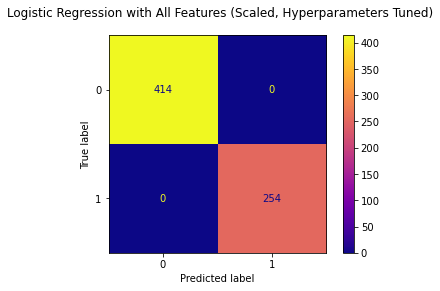

In [78]:
logreg_model = LogisticRegression(random_state=2021, solver="liblinear", penalty="l1")
logreg_model.fit(X_train, y_train)

fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with All Features (Scaled, Hyperparameters Tuned)")

plot_confusion_matrix(logreg_model, X_train, y_train, ax=ax, cmap="plasma");

## `SelectFromModel`

The last model is probably overfitting. We might try thinning out the number of features by eliminating the ones with small modeling coefficients:

In [79]:
selector = SelectFromModel(logreg_model)

selector.fit(X_train, y_train)

SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=2021,
                                             solver='liblinear'))

We're using the default threshold here:

In [80]:
thresh = selector.threshold_
thresh

1e-05

Let's get a sense of which features will be eliminated:

In [81]:
coefs = selector.estimator_.coef_
coefs

array([[-0.20271981, -0.02668007,  0.        , ...,  0.00044669,
         0.        , -0.07831913]])

In [82]:
coefs[coefs > thresh].shape

(148,)

In [83]:
selector.get_support()

array([ True,  True, False, ...,  True, False,  True])

In [84]:
dict(zip(X_train.columns, selector.get_support()))

{'Age': True,
 'SibSp': True,
 'Parch': False,
 'Fare': False,
 'Pclass_missing': False,
 'Name_missing': False,
 'Sex_missing': False,
 'Age_missing': False,
 'SibSp_missing': False,
 'Parch_missing': False,
 'Ticket_missing': False,
 'Fare_missing': False,
 'Cabin_missing': True,
 'Embarked_missing': False,
 1: False,
 2: False,
 3: True,
 'Abbing, Mr. Anthony': False,
 'Abbott, Mr. Rossmore Edward': False,
 'Abbott, Mrs. Stanton (Rosa Hunt)': False,
 'Abelson, Mr. Samuel': False,
 'Abelson, Mrs. Samuel (Hannah Wizosky)': False,
 'Adahl, Mr. Mauritz Nils Martin': False,
 'Adams, Mr. John': False,
 'Albimona, Mr. Nassef Cassem': True,
 'Alexander, Mr. William': False,
 'Alhomaki, Mr. Ilmari Rudolf': False,
 'Ali, Mr. William': False,
 'Allen, Miss. Elisabeth Walton': False,
 'Allen, Mr. William Henry': False,
 'Allison, Master. Hudson Trevor': True,
 'Allison, Miss. Helen Loraine': True,
 'Allison, Mrs. Hudson J C (Bessie Waldo Daniels)': True,
 'Allum, Mr. Owen George': False,
 'Ande

In [85]:
def select_important_features(X, selector):
    """
    Given a DataFrame and a selector, use the selector to choose
    the most important columns
    """
    imps = dict(zip(X.columns, selector.get_support()))
    selected_array = selector.transform(X)
    selected_df = pd.DataFrame(selected_array,
                               columns=[col for col in X.columns if imps[col]],
                               index=X.index)
    return selected_df

In [86]:
X_train_selected = select_important_features(X=X_train, selector=selector)

In [87]:
logreg_sel = LogisticRegression(random_state=2021, solver="liblinear", penalty="l1")

logreg_sel.fit(X_train_selected, y_train)

LogisticRegression(penalty='l1', random_state=2021, solver='liblinear')

In [88]:
cross_val_score(logreg_sel, X_train_selected, y_train, cv=3)

array([0.79820628, 0.86098655, 0.81531532])

Probably still overfitting, but let's call this our final model!

## Final Model Evaluation

Now that we have a final model, run X_test through all of the preprocessing steps so we can evaluate the model's performance

In [89]:
X_test_no_transformations = X_test.copy()

In [90]:
# add missing indicators
X_test_mi = add_missing_indicator_columns(X_test_no_transformations, indicator)

In [91]:
# separate out values for imputation
X_test_numeric = X_test_mi[numeric_feature_names]
X_test_categorical = X_test_mi[categorical_feature_names]

In [92]:
# impute missing values
X_test_numeric = impute_missing_values(X_test_numeric, numeric_imputer)
X_test_categorical = impute_missing_values(X_test_categorical, categorical_imputer)
X_test_imputed = pd.concat([X_test_numeric, X_test_categorical], axis=1)
X_test_new = X_test_mi.drop(numeric_feature_names + categorical_feature_names, axis=1)
X_test_final = pd.concat([X_test_imputed, X_test_new], axis=1)

In [93]:
# one-hot encode categorical data
for categorical_feature in categorical_feature_names:
    X_test_final = encode_and_concat_feature(X_test_final,
                                       categorical_feature, encoders[categorical_feature])

In [94]:
# scale values
X_test_scaled = scale_values(X_test_final, scaler)

In [95]:
# select features
X_test_selected = select_important_features(X_test_scaled, selector)

In [96]:
X_test_selected.head()

,Age,SibSp,Cabin_missing,3,"Albimona, Mr. Nassef Cassem","Allison, Master. Hudson Trevor","Allison, Miss. Helen Loraine","Allison, Mrs. Hudson J C (Bessie Waldo Daniels)","Anderson, Mr. Harry","Andersson, Mr. August Edvard (""Wennerstrom"")",...,D49,E10,E12,E17,E24,E25,E50,E77,C,S
210,-0.401365,-0.487594,0.551985,0.905629,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,...,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.489216,0.614263
876,-0.707519,-0.487594,0.551985,0.905629,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,...,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.489216,0.614263
666,-0.324827,-0.487594,0.551985,-1.104205,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,...,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.489216,0.614263
819,-1.472904,2.182185,0.551985,0.905629,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,...,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.489216,0.614263
736,1.435558,0.402332,0.551985,0.905629,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,...,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.03872,-0.489216,0.614263


Create a model with the relevant hyperparameters, fit, and score

In [97]:
final_model = LogisticRegression(random_state=2021, solver="liblinear", penalty="l1")
final_model.fit(X_train_selected, y_train)

final_model.score(X_test_selected, y_test)

0.7802690582959642

### Compare the past models

In [98]:
# Create a way to categorize our different models
model_candidates = [
    {
        'name':'logreg_model_more_iterations'
        ,'model':logreg_model_more_iterations
        ,'X_test':X_test_final
        ,'y_test':y_test
    },
    {
        'name':'logreg_model_more_regularization'
        ,'model':logreg_model_more_regularization
        ,'X_test':X_test_final
        ,'y_test':y_test
    },
    {
        'name':'logreg_model_higher_tolerance'
        ,'model':logreg_model_higher_tolerance
        ,'X_test':X_test_final
        ,'y_test':y_test
    },
    {
        'name':'dummy_model'
        ,'model':dummy_model
        ,'X_test':X_test
        ,'y_test':y_test
    },
    {
        'name':'simple_logreg_model'
        ,'model':simple_logreg_model
        ,'X_test':X_test_no_transformations[["SibSp", "Parch", "Fare"]]
        ,'y_test':y_test
    },
    {
        'name':'final_model'
        ,'model':final_model
        ,'X_test':X_test_selected
        ,'y_test':y_test
    }
]

In [99]:
final_scores_dict = {
    "Model Name": [candidate.get('name') for candidate in model_candidates],
    "Mean Accuracy": [
        candidate.get('model').score(
                                candidate.get('X_test'), 
                                candidate.get('y_test')
        ) 
        for candidate in model_candidates
    ]
    
}
final_scores_df = pd.DataFrame(final_scores_dict).set_index('Model Name')
final_scores_df

,Mean Accuracy
Model Name,
logreg_model_more_iterations,0.802691
logreg_model_more_regularization,0.744395
logreg_model_higher_tolerance,0.757848
dummy_model,0.605381
simple_logreg_model,0.650224
final_model,0.780269


Final comparison of confusion matrices

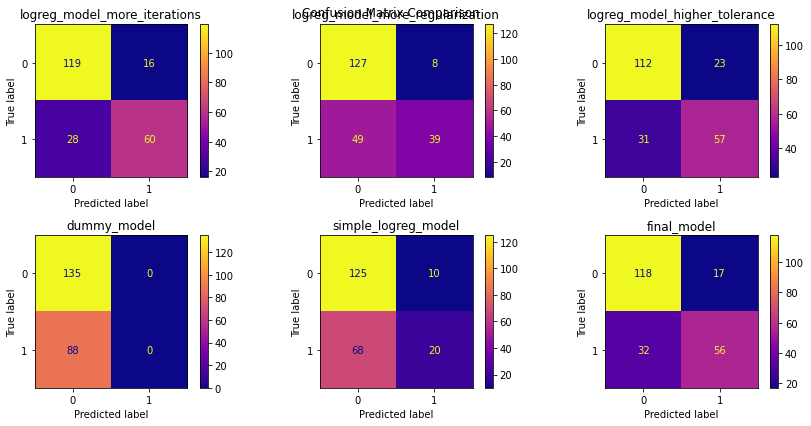

In [100]:
nrows = 2
ncols = round(len(model_candidates)/nrows)

fig, axes = plt.subplots(
                nrows=nrows,
                ncols=ncols,
                figsize=(12, 6)
)

fig.suptitle("Confusion Matrix Comparison")


for i,candidate in enumerate(model_candidates):
    # Logic for making rows and columns for matrices
    row = i // 3
    col = i % 3
    ax = axes[row][col]
    
    ax.set_title(candidate.get('name'))
    plot_confusion_matrix(
        candidate.get('model'),
        candidate.get('X_test'),
        candidate.get('y_test'),
        ax=ax,
        cmap="plasma"
    )
    
plt.tight_layout()

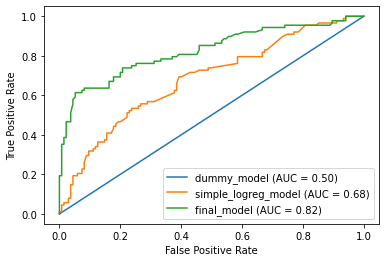

In [101]:
fig, ax = plt.subplots()

# Plot only the last models we created (so it's not too cluttered)
for model_candidate in model_candidates[3:]:
    plot_roc_curve(
        model_candidate.get('model'),
        model_candidate.get('X_test'),
        model_candidate.get('y_test'), 
        name=model_candidate.get('name'),
        ax=ax
    )

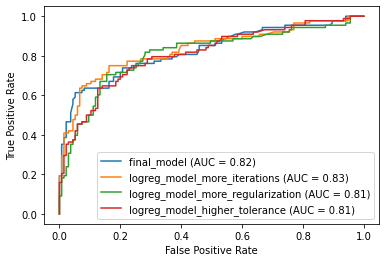

In [102]:
fig, ax = plt.subplots()

# Plot the final model against the other earlier models
plot_roc_curve(
    final_model, 
    X_test_selected, 
    y_test,
    name='final_model', 
    ax=ax
)

for model_candidate in model_candidates[:3]:
    plot_roc_curve(
        model_candidate.get('model'),
        model_candidate.get('X_test'),
        model_candidate.get('y_test'), 
        name=model_candidate.get('name'),
        ax=ax
    )

# Exercise

Build and iterate on a logistic regression model of **color** for the diamonds dataset! Maximize accuracy.

In [ ]:
diamonds = sns.load_dataset('diamonds')